In [1]:
using Plots
using NPZ
using SCYFI
using GTF
using LinearAlgebra

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\Lukas.Eisenmann\.julia\packages\Flux\vwk6M\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [2]:

function generate_bitflip_k(bitvector, k)
    M = length(bitvector)
    bitflip_k_versions = []
    mutable_bitvector = copy(bitvector)  # Create a mutable copy
    for indices in combinations(1:M, k)
        for i in indices
            mutable_bitvector[i] = !mutable_bitvector[i]
        end
        push!(bitflip_k_versions, copy(mutable_bitvector))  # Push a copy of the modified bitvector
        for i in indices  # Reset the modified bits back to original values
            mutable_bitvector[i] = !mutable_bitvector[i]
        end
    end
    return bitflip_k_versions
end


"""
ALRNN
"""
function get_latent_time_series_backwards(time_steps:: Integer, A:: Array, W:: Array, h:: Array, dz::Integer, num_relus::Integer; z_0:: Array= nothing,  D_pool::Any = [], traj=nothing, correction_T=nothing)
    if z_0 === nothing
        z = transpose(randn(1,dz))
    else
        z = z_0
    end
    trajectory = Array{Array}(undef, time_steps)
    trajectory[1] = z_0
    for t = 2:time_steps
        z,D_pool = latent_step_backwards(z, A, W, h, num_relus, D_pool)
        if z === nothing
            return trajectory[1:t-1],D_pool
        end
        #return if value out of interesting regime
        if any(abs.(z) .> 100000)
            return trajectory[1:t-1],D_pool
        end
        trajectory[t] = z
    end
    return trajectory,D_pool
end

"""
ALRNN step
"""
function latent_step_backwards(z:: Array, A:: Array, W:: Array, h::Array,num_relus::Integer, D_pool::Any)
    dims = size(A)[1]
    D = Diagonal(vcat(ones(dims-num_relus),z[end-(num_relus-1):end].>0))
    z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
    z_forward=latent_step(z_candidate, A, W, h,num_relus)
    if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
        D_int= parse(Int, join(diag(Bool.(D)) .|> (x -> x ? "1" : "0")), base=2)
        if D_int ∈ D_pool
            return z_candidate,D_pool
        else
            push!(D_pool,D_int)
            return z_candidate,D_pool
        end
    else
        D = Diagonal(vcat(ones(dims-num_relus),z_candidate[end-(num_relus-1):end].>0))
        z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
        z_forward=latent_step(z_candidate, A, W, h,num_relus)
        if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
            D_int= parse(Int, join(diag(Bool.(D)) .|> (x -> x ? "1" : "0")), base=2)
            if D_int ∈ D_pool
                return z_candidate,D_pool
            else
                push!(D_pool,D_int)
                return z_candidate,D_pool
            end	
        else
            #println("Test previously visited regions")
            for D_int in D_pool
                D = Diagonal(convert(Array{Bool},collect(bitstring(D_int)[length(bitstring(D_int))-dims+1:end]).=='1'))
                z_candidate =BigFloat.(Arblib.inv(A+W*D)*(z-h))
                z_forward=latent_step(z_candidate, A, W, h,num_relus)
                if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
                    return z_candidate,D_pool
                end
            end
            #println("entered combinatorics mode")
            D = Bool.(Diagonal(vcat(ones(dims-num_relus),z[end-(num_relus-1):end].>0)))
            for k=1:num_relus
               # println("Testing all flips of order $k")
                D_versions=generate_bitflip_k(diag(D)[end-(num_relus-1):end], k)
                for Ds in D_versions#0:0.1:50
                    D_=Diagonal(vcat(ones(dims-num_relus),Ds))
                    try
                        z_candidate =BigFloat.(Arblib.inv(A+W*D_)*(z-h))
                        z_forward=latent_step(z_candidate, A, W, h,num_relus)
                    catch ex 
                        if isa(ex,SingularException)
                            continue
                        else 
                            return error(ex)
                        end
                    end

                    if round.(Float64.(z),sigdigits=2) ≈ round.(Float64.(z_forward),sigdigits=2)
                        D_int= parse(Int, join(Bool.(diag(D_)) .|> (x -> x ? "1" : "0")), base=2)
                        if D_int ∈ D_pool
                            return z_candidate,D_pool
                        else
                            push!(D_pool,D_int)
                            return z_candidate,D_pool
                        end                        
                    end
                end
            end
            println(z)
            println(round.(Float64.(z),sigdigits=2))
            #println(z_candidate)
            println(round.(Float64.(z_forward),sigdigits=2))
            return nothing,D_pool #error("HEURISTIC FAILED YOU NEED TO FIND A DIFFERENT SOLUTION")
        end
   
    end
end

function euclidean_distance(p1, p2)
    return sqrt(sum((p1 .- p2) .^ 2))
end


euclidean_distance (generic function with 1 method)

In [4]:
data=npzread("C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI//Figures/Figure4/example cell/ExampleCell/lukas_data.npy")
model_path = "C:/Users/Lukas.Eisenmann/Documents/PhD/Code/SCYFI/Results/Example_cell_MAE_Condreg1e-5_4_noise_3/Empirical-M_ALRNN-O_Identity-T_100-clip_10.0-τ_10-M_15-relu_6-L2reg_0.3/003/checkpoints"
m, O = load_model(model_path*"/model_"*"1250"*".bson")
traj=generate(m,O,data[10,1:end],10000000)

10000000×6 Matrix{Float64}:
 -0.284151  -0.406783  -0.090522     -0.451963  -0.361603  -0.0647047
 -0.361178  -0.328346  -0.0381292    -0.426569  -0.293648  -0.057667
 -0.398662  -0.329925  -0.000956399  -0.42436   -0.303362  -0.036703
 -0.418779  -0.350129   0.0462133    -0.428931  -0.329914  -0.000231894
 -0.429806  -0.34793    0.123065     -0.434055  -0.333023   0.0589416
 -0.434824  -0.305929   0.228671     -0.437118  -0.295584   0.136644
 -0.436141  -0.246851   0.32778      -0.438003  -0.240552   0.206721
 -0.435704  -0.209177   0.376952     -0.437356  -0.204455   0.238273
 -0.430924  -0.183205   0.349948     -0.431594  -0.178505   0.210487
 -0.418636  -0.152982   0.21144      -0.416946  -0.146938   0.0950459
  ⋮                                                         ⋮
 -0.438301  -0.336873   0.0367571    -0.435151  -0.326113   0.0141264
 -0.44047   -0.326622   0.138239     -0.437816  -0.316018   0.0856689
 -0.442094  -0.314708   0.265627     -0.441357  -0.305167   0.176683
 -0.4

36


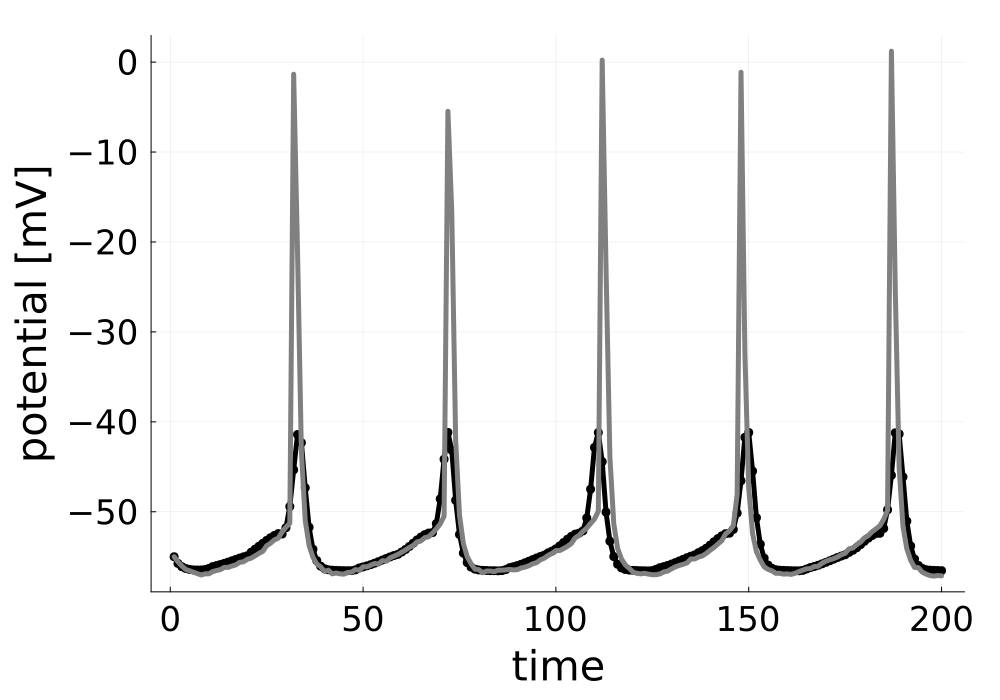

In [5]:
unique_points = unique(round.(traj[9999500:end,1],digits=3),dims=1)
println(length(unique_points))
mean = -0.05224843587548712
std = 0.00968304068272246

#smaller markersA
kl=plot([1:200],(traj[1:200,1].*std.+mean).*1000,markersize=5,label="generated",size=(1000,700),xtickfont=font(23), 
ytickfont=font(23),xguidefontsize=28,yguidefontsize=28,legendfont=font(22),linewidth=5,margin=7Plots.mm,color="black",legend=false,marker=:circle)
plot!([1:200],(data[10:209,1].*std.+mean).*1000,label="data",color="gray",linewidth=5)
xlabel!("time")
ylabel!("potential [mV]")




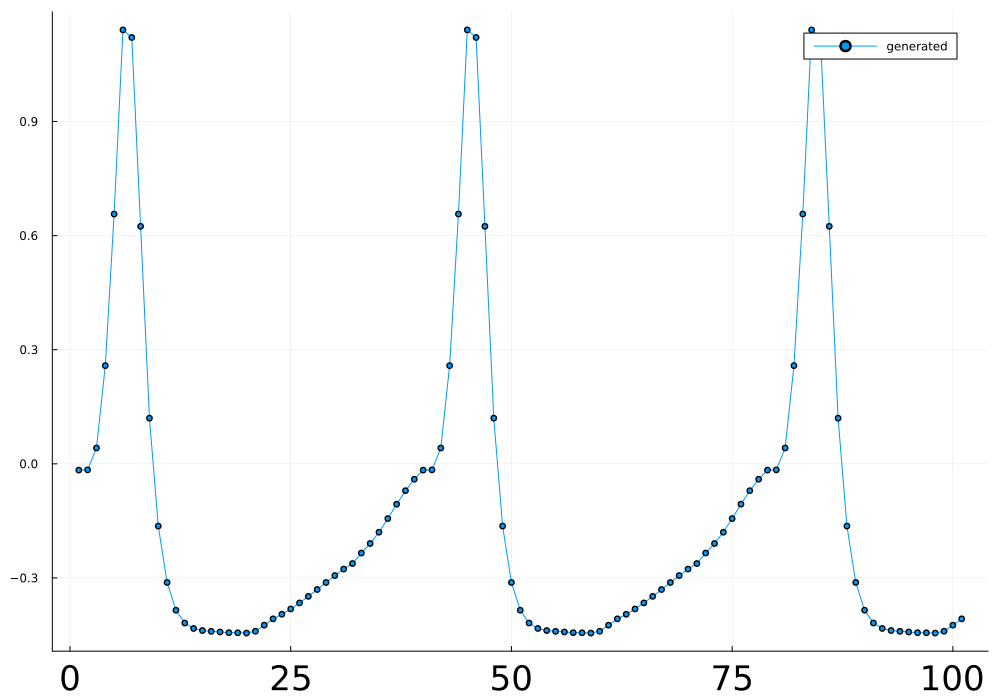

In [10]:
plot(traj[9999900:end,1],markersize=3,marker=:circle,label="generated",size=(1000,700),xtickfont=font(23))

In [7]:
A=diagm(m.A)
W=m.W
h=m.h
num_relus=m.n
dims = size(A)[1]

15

In [8]:
res=find_cycles(A,W,h,num_relus,1,outer_loop_iterations=400,inner_loop_iterations=1000,)

cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[0.06528273, -0.59328306, -0.39654195, 0.14302559, -0.56623673, -0.30965284, 0.60439986, -0.3172676, 0.1446518, 0.40436015, 0.57547444, -1.8297485, 0.7240586, -0.02591609, 1.4690576]], Array[Float32[0.11649009, -0.16853245, -0.30049473, 0.17893712, -0.1782103, -0.2990857, -0.17946461, -0.21477531, -0.20773347, 0.3814065, 0.16345195, 0.1608581, 0.023629554, -0.19808231, 0.18446496]], Array[Float32[0.0990037, -0.6349637, -0.41393846, 0.18219459, -0.6047759, -0.31922945, 0.6957567, -0.2777895, 0.22360262, 0.46849138, 0.60551566, -2.0567253, 0.7606903, 0.05156006, 1.6066536]]]]
 [Array[ComplexF32[0.3853027f0 + 0.0f0im, 0.416313f0 - 0.007100248f0im, 0.416313f0 + 0.007100248f0im, 0.4392916f0 - 0.59305394f0im, 0.4392916f0 + 0.59305394f0im, 0.43940288f0 - 0.21790586f0im, 0.43940288f0 + 0.21790586f0im, 0.5524095f0 - 0.4827107f0im, 0.5524095f0 + 0.4827107f0im, 0.64972615f0 + 0.0f0im, 0.77341175f0 + 0.0f0im, 0.89991134f0 + 0.0f0im, 0.90529925f

In [8]:
println(length(res[2][1]))
for i=1:length(res[2][1])
    println(all.(abs.(res[2][1][i]).<1))
    println(all(abs.(res[2][1][i]).<1))
end


3
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
true
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
false
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
false


In [11]:
res=find_cycles(A,W,h,num_relus,[1,39,40],outer_loop_iterations=5000,inner_loop_iterations=5000,PLRNN=SCYFI.ALRNN())


cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[0.11649009, -0.16853245, -0.30049473, 0.17893712, -0.1782103, -0.2990857, -0.17946461, -0.21477531, -0.20773347, 0.3814065, 0.16345195, 0.1608581, 0.023629554, -0.19808231, 0.18446496]], Array[Float32[0.0990037, -0.6349637, -0.41393846, 0.18219459, -0.6047759, -0.31922945, 0.6957567, -0.2777895, 0.22360262, 0.46849138, 0.60551566, -2.0567253, 0.7606903, 0.05156006, 1.6066536]], Array[Float32[0.06528273, -0.59328306, -0.39654195, 0.14302559, -0.56623673, -0.30965284, 0.60439986, -0.3172676, 0.1446518, 0.40436015, 0.57547444, -1.8297485, 0.7240586, -0.02591609, 1.4690576]]], Array[Array[Float32[-0.3118853, 0.14027385, -0.4375802, -0.30038238, 0.133977, -0.43855956, -0.99988896, -0.1594232, 1.2224352, -2.1621952, -6.7349477, 3.3336601, -9.039332, -3.429527, -2.036068], Float32[-0.29366243, 0.32350737, -0.44743717, -0.2807451, 0.28602144, -0.44351828, -0.46027315, 0.5166961, 1.8193624, -1.3031697, -6.714823, 2.5638304, -9.111094, -2.05

In [13]:
res2=find_cycles(A,W,h,num_relus,[1,39],outer_loop_iterations=1000,inner_loop_iterations=1000,PLRNN=SCYFI.ALRNN())


cpu version


2-element Vector{Vector{Array}}:
 [Array[Array[Float32[0.11649009, -0.16853245, -0.30049473, 0.17893712, -0.1782103, -0.2990857, -0.17946461, -0.21477531, -0.20773347, 0.3814065, 0.16345195, 0.1608581, 0.023629554, -0.19808231, 0.18446496]], Array[Float32[0.0990037, -0.6349637, -0.41393846, 0.18219459, -0.6047759, -0.31922945, 0.6957567, -0.2777895, 0.22360262, 0.46849138, 0.60551566, -2.0567253, 0.7606903, 0.05156006, 1.6066536]], Array[Float32[0.06528273, -0.59328306, -0.39654195, 0.14302559, -0.56623673, -0.30965284, 0.60439986, -0.3172676, 0.1446518, 0.40436015, 0.57547444, -1.8297485, 0.7240586, -0.02591609, 1.4690576]]], Array[Array[Float32[-0.2937683, 0.3224156, -0.44743478, -0.28085554, 0.28512678, -0.44354713, -0.46402022, 0.5122094, 1.8161422, -1.3100427, -6.718279, 2.5700793, -9.114735, -2.0645912, -1.2509855], Float32[-0.27675682, 0.5392007, -0.45083034, -0.26311976, 0.46841273, -0.44369954, 0.10244359, 1.0548525, 2.1925154, -0.4277022, -6.401885, 1.7592797, -8.660308, -0.6

In [23]:
abs.(res2[2][2][1])



15-element Vector{Float32}:
 5.822818f-6
 9.3800685f-7
 8.603837f-8
 1.2036159f-7
 1.2036159f-7
 2.2565187f-8
 2.2565187f-8
 2.204728f-9
 9.920118f-9
 0.000121489604
 0.000121489604
 0.004338842
 0.004338842
 0.021749362
 0.3854683

In [11]:
using JSON
function complex_to_dict(z::Complex)
    return Dict("real" => real(z),"imag" => imag(z))
end
# Function to process arrays recursively
function process_array(arr)
    return map(arr) do x
        if x isa Array
            process_array(x)
        elseif x isa Complex
            complex_to_dict(x)
        else
            x
        end
    end
end

# Create the data structure to save
data = Dict(
    "cycles" => process_array(res)
)

# Save to JSON file
open(model_path*"dynamical_objects.json", "w") do f
    JSON.print(f, data, 4)  # The 4 argument adds pretty printing with indentation
end

In [15]:
println(length.(res[1][1]))

[38]


In [12]:
println(length(res[2][1]))

1
